In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data = '/content/gdrive/MyDrive/Colab Notebooks/SolarPanel/Faulty_solar_panel'
filepaths = []
labels = []

folds = os.listdir(data)
for fold in folds:
    foldpath = os.path.join(data, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
data

filepaths        labels
0    /content/gdrive/MyDrive/Colab Notebooks/SolarP...     Bird-drop
1    /content/gdrive/MyDrive/Colab Notebooks/SolarP...     Bird-drop
2    /content/gdrive/MyDrive/Colab Notebooks/SolarP...     Bird-drop
3    /content/gdrive/MyDrive/Colab Notebooks/SolarP...     Bird-drop
4    /content/gdrive/MyDrive/Colab Notebooks/SolarP...     Bird-drop
..                                                 ...           ...
871  /content/gdrive/MyDrive/Colab Notebooks/SolarP...  Snow-Covered
872  /content/gdrive/MyDrive/Colab Notebooks/SolarP...  Snow-Covered
873  /content/gdrive/MyDrive/Colab Notebooks/SolarP...  Snow-Covered
874  /content/gdrive/MyDrive/Colab Notebooks/SolarP...  Snow-Covered
875  /content/gdrive/MyDrive/Colab Notebooks/SolarP...  Snow-Covered

[876 rows x 2 columns]

In [5]:
# train df
train_df, temp_df = train_test_split(data,  train_size= 0.8, shuffle= True, random_state= 42)

# valid and test df
valid_df, test_df = train_test_split(temp_df,  train_size= 0.6, shuffle= True, random_state= 42)

In [6]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 694 validated image filenames belonging to 6 classes.
Found 104 validated image filenames belonging to 6 classes.
Found 71 validated image filenames belonging to 6 classes.


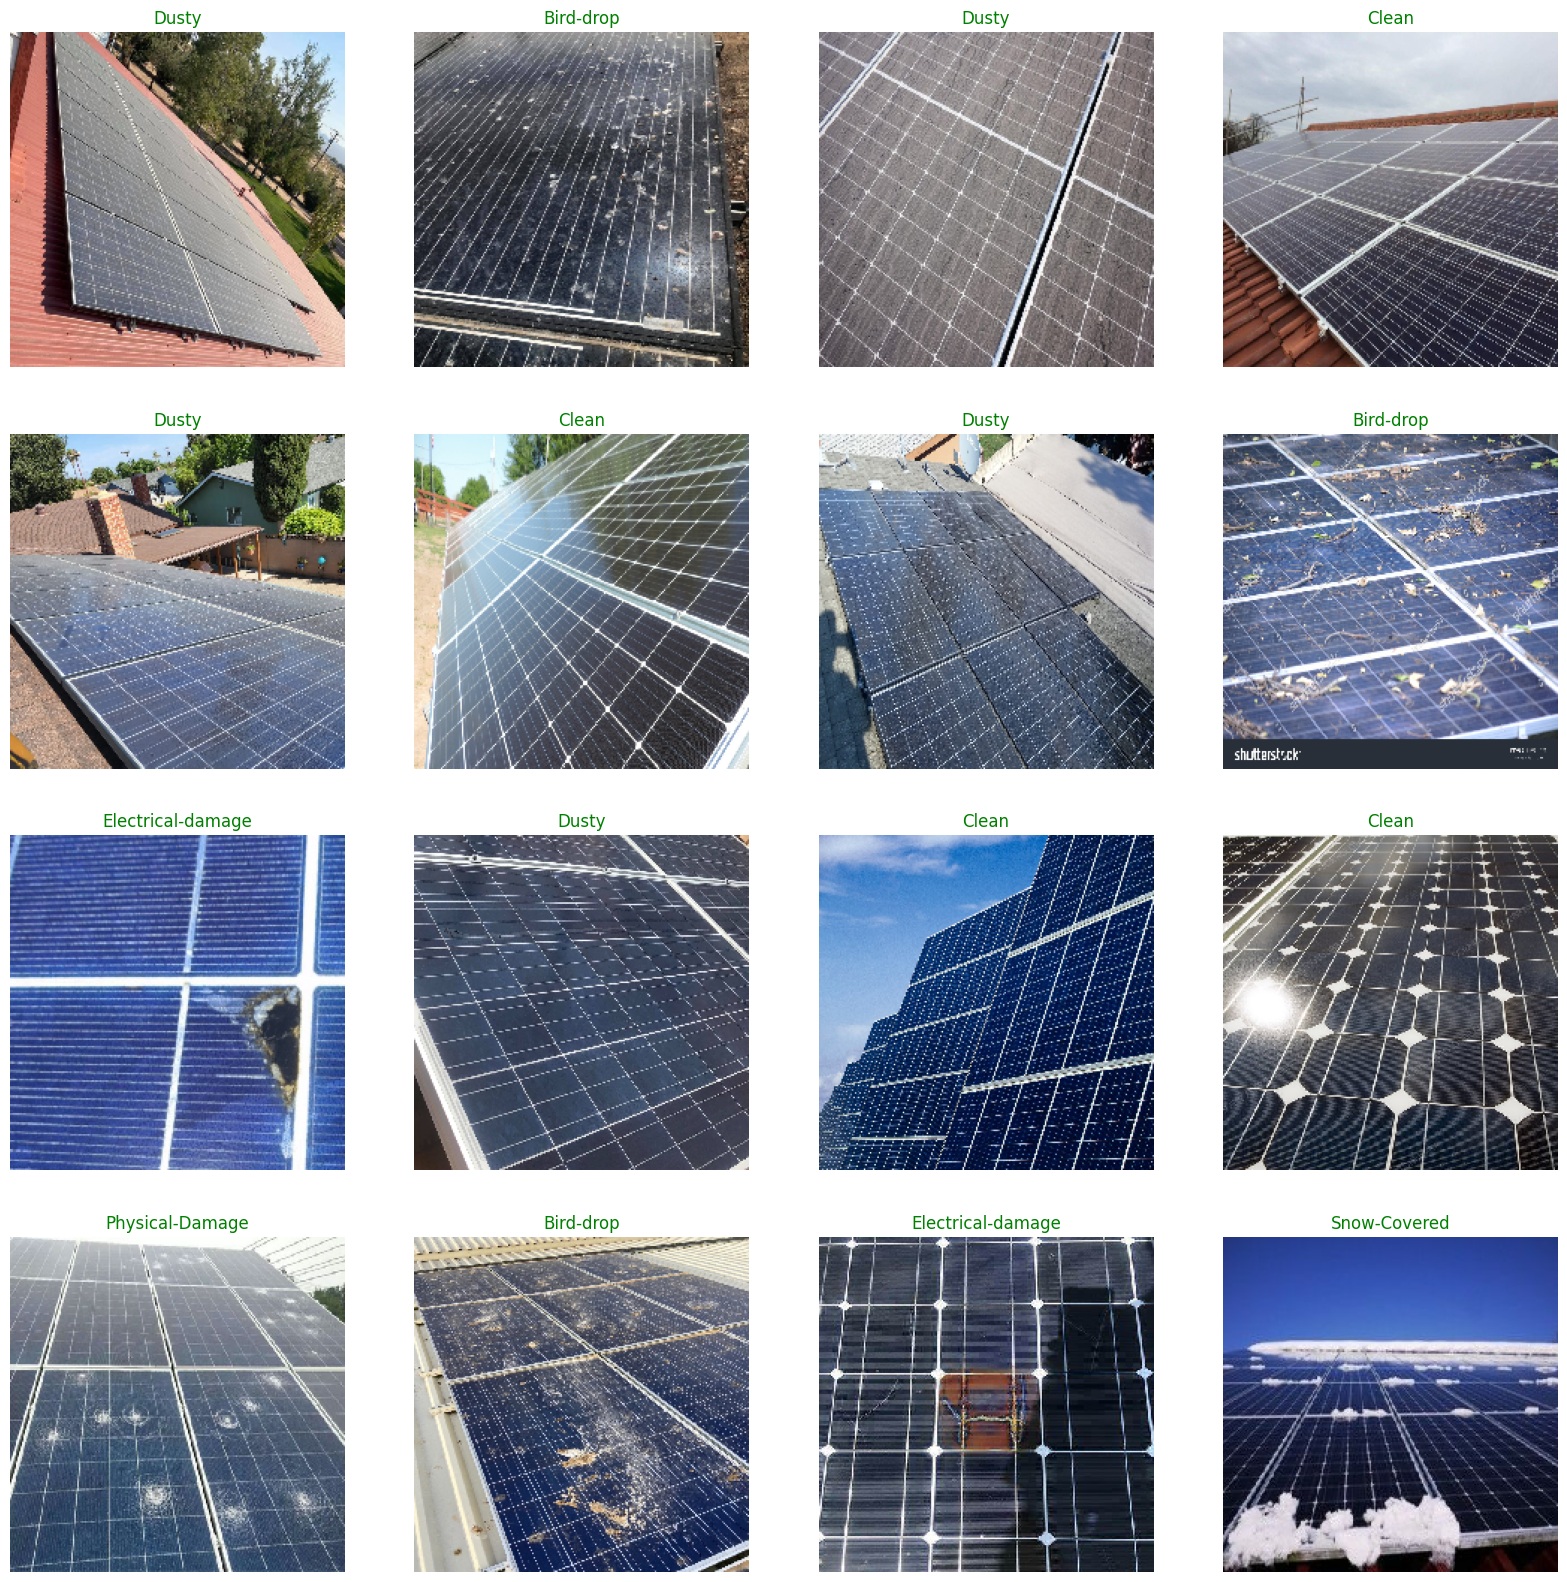

In [7]:
# Retrieving class names
classes = list(train_gen.class_indices.keys())

# Retrieving data and labels
images, labels = next(train_gen)

# Displaying images
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)

    # Normalizing images
    image = images[i] / 255

    # Displaying images
    plt.imshow(image)

    # Getting class index from labels
    label_index = np.argmax(labels[i])

    # Getting the class name
    class_name = classes[label_index]

    # Visual title and appearance
    plt.title(class_name, color='green', fontsize=12)
    plt.axis('off')

plt.show()


In [8]:

img_size = (224, 224)
channels = 3
img_shape = (*img_size, channels)
class_count = len(train_gen.class_indices)


base_model = tf.keras.applications.densenet.DenseNet121(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
#base_model = tf.keras.applications.vgg16.VGG16(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
#base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.016),
                activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006)))
model.add(Dropout(rate=0.45, seed=42))
model.add(Dense(class_count, activation='softmax'))

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 7305542 (27.87 MB)
Trainable params: 721984

In [9]:
batch_size = 20
epochs =  25

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/25
44/44 [==============================] - 322s 6s/step - loss: 7.5084 - accuracy: 0.5288 - val_loss: 11.7819 - val_accuracy: 0.3269
Epoch 2/25
44/44 [==============================] - 18s 399ms/step - loss: 5.7853 - accuracy: 0.7781 - val_loss: 6.3440 - val_accuracy: 0.5673
Epoch 3/25
44/44 [==============================] - 18s 411ms/step - loss: 4.9349 - accuracy: 0.8718 - val_loss: 5.1662 - val_accuracy: 0.7500
Epoch 4/25
44/44 [==============================] - 18s 408ms/step - loss: 4.3103 - accuracy: 0.9280 - val_loss: 4.5669 - val_accuracy: 0.7885
Epoch 5/25
44/44 [==============================] - 18s 408ms/step - loss: 3.8394 - accuracy: 0.9697 - val_loss: 4.2679 - val_accuracy: 0.8077
Epoch 6/25
44/44 [==============================] - 18s 403ms/step - loss: 3.4922 - accuracy: 0.9784 - val_loss: 3.7735 - val_accuracy: 0.7981
Epoch 7/25
44/44 [==============================] - 21s 478ms/step - loss: 3.1738 - accuracy: 0.9841 - val_loss: 3.5367 - val_accuracy: 0.7981


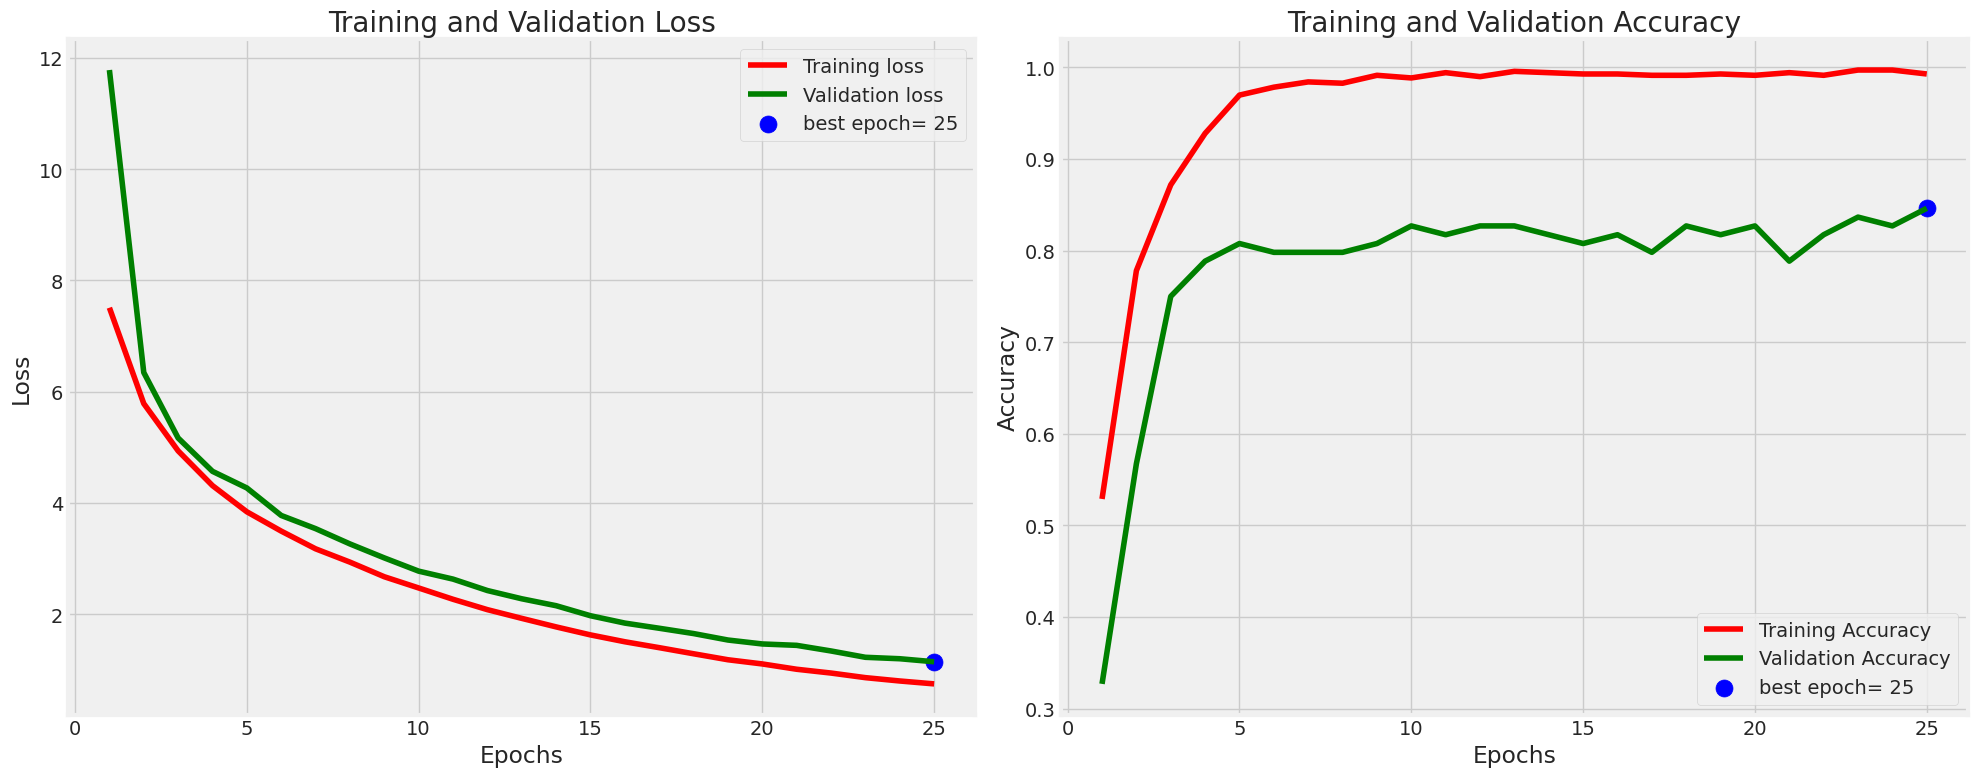

In [10]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = range(1, len(tr_acc) + 1)
loss_label = f'best epoch= {index_loss + 1}'
acc_label = f'best epoch= {index_acc + 1}'


plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
ts_length = len(test_df)
factors = [n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]
test_batch_size = max(sorted([ts_length // n for n in factors]))

test_steps = ts_length // test_batch_size

scores = {}
datasets = {'Train': train_gen, 'Validation': valid_gen, 'Test': test_gen}

for dataset_name, dataset in datasets.items():
    scores[dataset_name] = model.evaluate(dataset, steps=test_steps, verbose=1)

for dataset_name, score in scores.items():
    print(f"{dataset_name} Loss: {score[0]}")
    print(f"{dataset_name} Accuracy: {score[1]}")
    print('-' * 20)

1/1 [==============================] - 0s 262ms/step - loss: 0.9819 - accuracy: 0.9375
Train Loss: 0.6755479574203491
Train Accuracy: 1.0
--------------------
Validation Loss: 1.1547671556472778
Validation Accuracy: 0.875
--------------------
Test Loss: 0.9818826913833618
Test Accuracy: 0.9375
--------------------


In [12]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

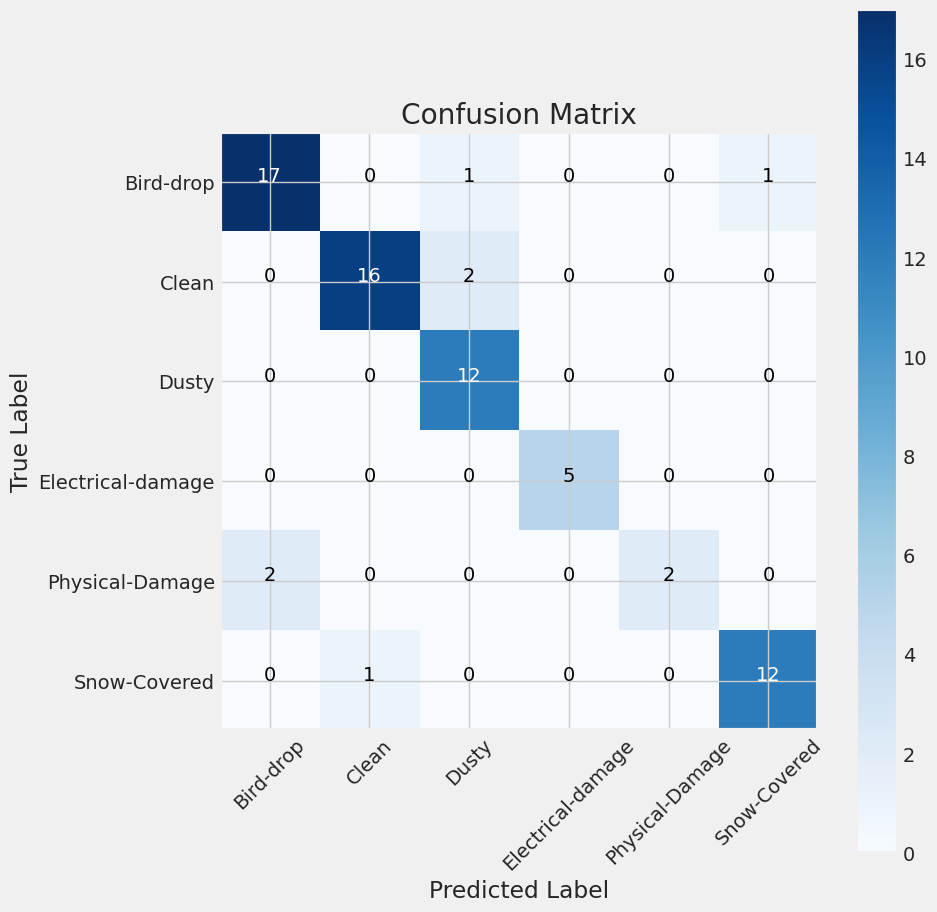

In [13]:
classes_test = list(test_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes_test))
plt.xticks(tick_marks, classes_test, rotation=45)
plt.yticks(tick_marks, classes_test)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [14]:
print(classification_report(test_gen.classes, y_pred, target_names= classes_test))

                   precision    recall  f1-score   support

        Bird-drop       0.89      0.89      0.89        19
            Clean       0.94      0.89      0.91        18
            Dusty       0.80      1.00      0.89        12
Electrical-damage       1.00      1.00      1.00         5
  Physical-Damage       1.00      0.50      0.67         4
     Snow-Covered       0.92      0.92      0.92        13

         accuracy                           0.90        71
        macro avg       0.93      0.87      0.88        71
     weighted avg       0.91      0.90      0.90        71



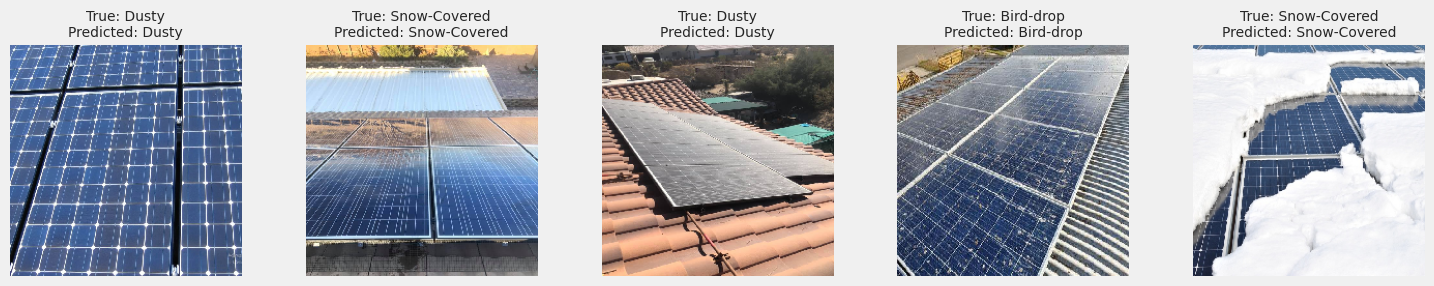

In [15]:
true_labels = test_gen.classes
num_samples_to_display = min(5, len(test_gen))
num_rows = 1
num_cols = num_samples_to_display // num_rows

indices = np.random.choice(len(test_gen), num_samples_to_display, replace=False)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3))
for i, idx in enumerate(indices):
    images, labels = test_gen[idx]
    image = images[0]

    image = image.astype('float32') / 255.0
    true_label = classes[true_labels[idx]]
    predicted_label = classes[y_pred[idx]]

    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
#Save the model
model.save('Solar Panel dust.h5')

In [17]:
loaded_model = tf.keras.models.load_model('/content/Solar Panel dust.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [18]:
image_path = '/content/ornek.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 4s 4s/step
Clean
